## トーンカーブ補正

### この節について

この節ではトーンカーブ補正について解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには目次ページ[(http://bit.ly/raw\_toc)](http://bit.ly/raw_toc)から参照するか、以下のURLからアクセスしてください。

[http://bit.ly/raw\_chap\_5\_4](http://bit.ly/raw_chap_5_4)

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then \
    wget http://bit.ly/raw_process -O raw_process.py; fi

from raw_process import simple_demosaic, white_balance, \
    black_level_correction, gamma_correction, demosaic, \
    defect_correction, color_correction_matrix, \
    lens_shading_correction, noise_filter, apply_matrix, \
    edge_enhancement

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then \
    wget http://bit.ly/raw_chart_jpg -O chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロード。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
# もし日本語が文字化けしている場合以下の３行の行頭の#を削除して実行後、
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json
# その後Runtime->Restart Runtime選択してページ全体を再実行

### ヒストグラムとトーンカーブ

前回までに作成した画像を表示します。

In [0]:
blc, pattern = raw.black_level_per_channel, raw.raw_pattern
blc_raw = black_level_correction(raw_array, blc, pattern)
threshold = 16
dpc_raw = defect_correction(blc_raw, threshold)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(dpc_raw, lsc)
gains, colors = raw.camera_whitebalance, raw.raw_colors
wb_raw = white_balance(lsc_raw, gains, colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array(
    [6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)
sigma, edge_intensity = 2, 0.25
shp_img = edge_enhancement(gmm_img, sigma, edge_intensity)

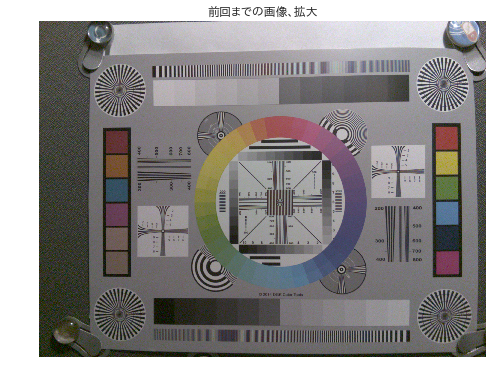

In [4]:
# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(shp_img)
plt.axis('off')
plt.title(u"前回までの画像、拡大")
plt.show()

この画像の輝度成分のヒストグラムを見てみましょう。

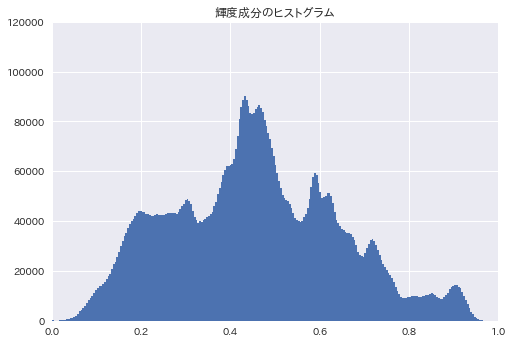

In [5]:
rgb2ycbcr = np.array([[0.299, 0.587, 0.144], 
                      [-0.168736, -0.331264, 0.5], 
                      [0.5, -0.418688, -0.081312]])
ycr_img = apply_matrix(shp_img, rgb2ycbcr)
luma = ycr_img[:, :, 0]

plt.hist(luma.flatten(), 256)
plt.axis((0, 1, 0, 120000))
plt.title("輝度成分のヒストグラム")
plt.show()

特におかしなところはありませんが、全体に中央に集まっていて、せっかくの256階調のダイナミックレンジを十分には使い切っていないことがわかります。

このような画像のダイナミックレンジ拡張方法としてヒストグラム平坦化というものがあります。これは、ヒストグラムの積算値と同じ形をした関数を元の画像に適用することでヒストグラムを平坦にしてしまう、というものです。しかし、ヒストグラムを完全に平坦にしてしまうと大概は不自然な画像になってしまいます。ここでは、そこまで極端でない補正をかけたいところです。

実際のカメラの中では非常に複雑なアルゴリズムでトーンカーブ補正を計算しますが、その部分は今回の記事では対象ではありませんので、適当にちょうど良さそうな関数を設定してトーンカーブ補正の画像処理の部分だけ行ってみましょう。

先程のヒストグラムをみると中央部分が高いので、この部分をバラけさせるために、0.5付近で急になる関数をかけましょう。まず適当なアンカーポイントを設定します。

In [0]:
xs = [0, 0.28, 0.78, 1.0]
ys = [0, 0.22, 0.88, 1.0]

図示するとこうなります

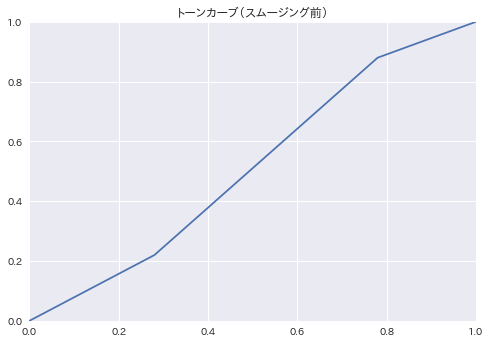

In [7]:
plt.plot(xs, ys)
plt.axis((0, 1, 0, 1))
plt.title("トーンカーブ（スムージング前）")
plt.show()

この関数をそのまま使うと折れ曲がっている周辺で何らかのアーティファクトが発生しそうです。 スプライン関数を利用して、スムースな関数を用意しましょう。

scipyのinterpolate.splrepに入力点と出力点の値を渡すと、スプライン関数で補完した関数を作ってくれます。

In [0]:
import scipy
func = scipy.interpolate.splrep(xs, ys)

この関数を図示するとこうなります。

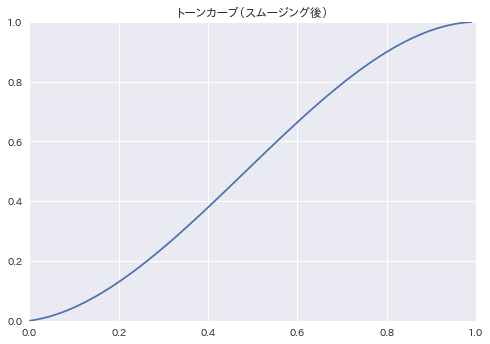

In [9]:
xx = np.arange(0, 1.0, 0.01)
# splevはsplrepで作成した関数を実際に適用する。
yy = scipy.interpolate.splev(xx, func)
plt.plot(xx, yy)
plt.axis((0, 1.0, 0, 1.0))
plt.title("トーンカーブ（スムージング後）")
plt.show()

よさそうな関数ができました。輝度信号に適用してみましょう。

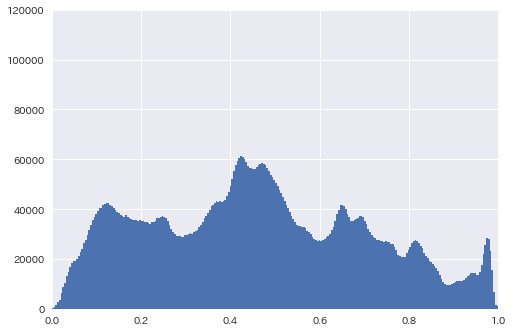

In [10]:
# splev関数を使って元の輝度画像にトーンカーブを適用する。
adjusted = scipy.interpolate.splev(luma, func)

# ヒストグラムの表示。
plt.hist(adjusted.flatten(), 256)
plt.axis((0, 1, 0, 120000))
plt.show()

先程よりもダイナミックレンジの広い範囲を有効に活用していることがわかります。
フルカラーに変換します[^3]。

[^3]: 本来色差成分（Cb/Cr)も調整しなくてはならないのですが今回は省きます。

In [0]:
# 元のYCbCr画像のうち輝度信号だけをトーンカーブ後のものに置き換える。
ton_img = ycr_img.copy()
ton_img[:, :, 0] = adjusted
# 逆行列の計算を使ってYCbCrからRGBに変換する行列を求める。
ycbcr2rgb = np.linalg.inv(rgb2ycbcr)
# YCbCr空間からRGB空間への変換。
out_img = apply_matrix(ton_img, ycbcr2rgb)
out_img[out_img<0] = 0
out_img[out_img>1] = 1

トーンカーブ補正後の画像を補正前の画像と比べてみましょう。

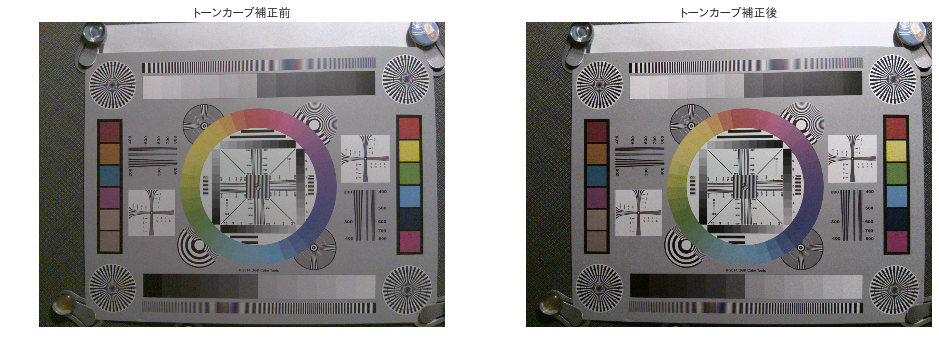

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(shp_img)
plt.axis('off')
plt.title('トーンカーブ補正前')
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.axis('off')
plt.title('トーンカーブ補正後')
plt.show()

補正前の画像より黒がより黒く白も若干明るくなり、メリハリがついて画像の印象がパリッとしました。

### モジュールへの追加

エッジ強調もモジュールとして追加しておきます。

In [0]:
# RGBからYCbCrへの変換行列。
RGB_TO_YCBCR = np.array([[0.299, 0.587, 0.144],
                         [-0.168736, -0.331264, 0.5],
                         [0.5, -0.418688, -0.081312]])

def tone_curve_correction(rgb_img, xs=(0, 0.25, 0.75, 1.0), 
                          ys=(0, 0.25, 0.75, 1.0)):
    """
    トーンカーブ補正。

    Parameters
    ----------
    rgb_img: numpy 3d array
        入力RGB画像
    xs: float array
        トーンカーブのアンカーポイントのX座標（入力値）。
    ys: float array
        トーンカーブのアンカーポイントのY座標（出力値）。

    Returns
    -------
    out_img: numpy array
        トーンカーブ補正後の画像
    """
    func = scipy.interpolate.splrep(xs, ys)
    ycr_img = apply_matrix(rgb_img, RGB_TO_YCBCR)
    ycr_img[:, :, 0] = scipy.interpolate.splev(ycr_img[:, :, 0], func)
    ycbcr2rgb = np.linalg.inv(RGB_TO_YCBCR)
    rgb_out = apply_matrix(ycr_img, ycbcr2rgb)
    rgb_out[rgb_out<0] = 0
    rgb_out[rgb_out>1] = 1
    return rgb_out

この関数を使って処理を行い動作を確認します。

In [0]:
tone_x, tone_y = (0, 0.28, 0.78, 1.0), (0, 0.22, 0.88, 1.0)
ton_img = tone_curve_correction(shp_img, tone_x, tone_y)

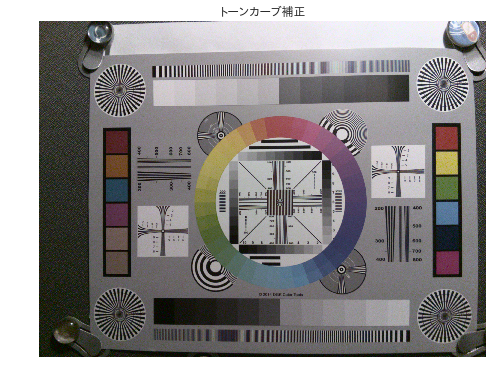

In [15]:
# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(ton_img)
plt.axis('off')
plt.title(u"トーンカーブ補正")
plt.show()

うまく処理できているようです。

この`tone_curve_correction()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

```
! wget http://bit.ly/raw_process -O raw_process.py
```

としてダウンロードした後、

```
from raw_process import tone_curve_correction
```

としてインポートしてください。

### まとめ

今回はトーンカーブ補正を行いました。ここではトーンカーブを手動で設定しましたが、カメラの中では画像の内容や状況に応じて自動的に最適なトーンカーブを設定します。この本の範囲を超えるのであつかいませんが、こういったアルゴリズムもそれ自体かなり重要な処理です。
またここで扱ったものは画像全体に一律のトーンカーブを使いますがこういったものはグローバル・トーンカーブ補正と呼ばれます。さらに高度な処理では画像内の領域ごとにコントラストの調整を行ったりします。興味がある方は論文など参照されてはどうでしょうか？

これで画質を良くする処理の章は終わりです。次は[応用編](http://bit.ly/raw_chap_6_1)に入ります。